In [1]:
import numpy as np
import pandas as pd
import nltk
from nltk.util import ngrams
from collections import defaultdict
from itertools import combinations
from multiprocessing import Pool
import time
import matplotlib.pyplot as plt

In [2]:
books = pd.read_csv("data_sets/Books_Raw.csv", usecols = ['Title'])
books['book_id'] = None
print(books.head())

                                               Title book_id
0                     Its Only Art If Its Well Hung!    None
1                           Dr. Seuss: American Icon    None
2              Wonderful Worship in Smaller Churches    None
3                      Whispers of the Wicked Saints    None
4  Nation Dance: Religion, Identity and Cultural ...    None


In [3]:
def generate_ngrams(text, n=3):
    tokens = [token for token in text if token != ' ']  # Remove spaces
    n_grams = ngrams(tokens, n)
    return [''.join(gram) for gram in n_grams]

In [4]:
def assign_book_ids(df_in, n=3, threshold=0.8):
    df = df_in.copy()
    book_id = 1
    title_to_id = {}
    ngram_to_id = defaultdict(int)  # Change to defaultdict(int) for incrementing IDs
    for index, row in df.iterrows():
        title = row['Title']
        # Check for NaN values
        if pd.isna(title):
            continue
        # Generate n-grams from the title
        title_ngrams = set(ngrams(title.lower(), n))
        # Check if similar title already exists
        assigned_id = None
        for ngram_set, id in ngram_to_id.items():
            common_ngrams = title_ngrams.intersection(ngram_set)
            similarity = len(common_ngrams) / max(len(ngram_set), len(title_ngrams), 1)
            if similarity > threshold:
                assigned_id = id
                break
        if assigned_id is None:
            # If no similar title found, assign a new book ID
            assigned_id = book_id
            book_id += 1
        # Update title_to_id and ngram_to_id mappings
        title_to_id[title] = assigned_id
        ngram_to_id[tuple(title_ngrams)] = assigned_id
        # Assign the book ID to the dataframe
        df.at[index, 'book_id'] = assigned_id
    return df

### PoC: it works

In [5]:
books_dummy = books.copy()
books_dummy.iloc[2,0] = "Only Art If Its Well Hung!"
df_dummy = assign_book_ids(books_dummy.head(5), threshold=0.8)
print(df_dummy)

                                               Title book_id
0                     Its Only Art If Its Well Hung!       1
1                           Dr. Seuss: American Icon       2
2                         Only Art If Its Well Hung!       1
3                      Whispers of the Wicked Saints       3
4  Nation Dance: Religion, Identity and Cultural ...       4


### Save for realsies

In [6]:
out = assign_book_ids(books)

In [7]:
out.to_csv('data_sets/duplicate_detection_with_ngrams.csv', index=False)

In [8]:
import datetime
now = datetime.datetime.now()
now

datetime.datetime(2024, 5, 25, 4, 44, 3, 537389)

### Experiment with the threshold

In [19]:
df08 = assign_book_ids(books.head(5000), threshold=0.8)
df09 = assign_book_ids(books.head(5000), threshold=0.9)

In [20]:
def find_duplicates(df):
    counts = df.groupby("book_id").size()
    duplicates = counts[counts > 1]
    duplicate_titles = df[df["book_id"].isin(duplicates.index.tolist())].sort_values("book_id")
    print(len(duplicates))
    return duplicate_titles["Title"].tolist()

In [21]:
find_duplicates(df08)

32


['Guide to Owning a Birman Cat (Popular Cat Library)',
 'Guide to Owning a Burmese Cat (Popular Cat Library)',
 'The "Canary" murder case (Gregg Press mystery fiction series)',
 'The kennel murder case (Gregg Press mystery fiction series)',
 'The Bishop murder case (Gregg Press mystery fiction series)',
 'Get Ready! For Standardized Tests : Math Grade 3',
 'Get Ready! For Standardized Tests : Reading Grade 3',
 'Get Ready! For Standardized Tests : Math Grade 4',
 'Born Royal (Firstborn Sons) (Silhouette Intimate Moments)',
 'Born In Secret (Firstborn Sons) (Silhouette Intimate Moments)',
 "The Collector's Edition of Victorian Lesbian Erotica",
 "The Collector's Edition of Victorian Erotica",
 'Lorna Doone;: A romance of Exmoor,',
 'Lorna Doone: A romance of Exmoor',
 'Chopin ;: The man and his music',
 'Chopin;: The man and his music,',
 'Chopin: The Man and His Music',
 'Say It in Russian (Revised) (Dover Language Guides Say It Series)',
 'Say It in Swedish (Revised) (Dover Language G

In [22]:
find_duplicates(df09)

14


['Get Ready! For Standardized Tests : Math Grade 3',
 'Get Ready! For Standardized Tests : Math Grade 4',
 'Five Star Stories #1',
 'Five Star Stories #4',
 'Vein of iron',
 'Vein of Iron',
 'Heaven Help The Home',
 'Heaven Help the Home!',
 'Colloquial Hindi: The Complete Course for Beginners (Colloquial Series)',
 'Colloquial Hindi, 2e: The Complete Course for Beginners (Colloquial Series)',
 'The adventures of a tropical tramp',
 'The Adventures of a Tropical Tramp',
 'World in Eclipse',
 'World in eclipse',
 "Baird's Manual of American College Fraternities",
 "Baird's manual of American college fraternities",
 "Flirting with Danger: Young Women's Reflections on Sexuality and Domination (Qualitative Studies in Psychology Series)",
 "Flirting with Danger: Young Women's Reflections on Sexuality and Domination (Qualitative Studies in Psychology)",
 'The Social Importance of Self Esteem',
 'The Social Importance of Self-Esteem',
 'Clarence Goes to Town',
 'clarence goes to town',
 'The 

### Estimating timings

In [10]:
def my_time(n):
    start_time = time.time()
    assign_book_ids(books_dummy.head(n))
    end_time = time.time()
    return end_time - start_time

In [11]:
samples = [200, 500, 1000, 1500, 2000, 2500, 3000]

points = [(n, my_time(n)) for n in samples]

In [12]:
x_values = [point[0] for point in points]
y_values = [point[1] for point in points]

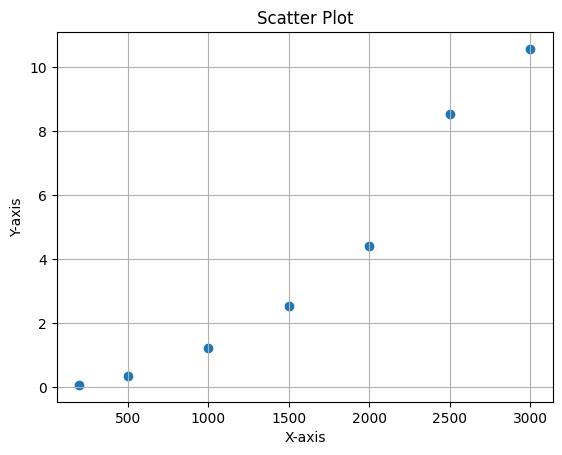

In [13]:
# Scatter plot
plt.scatter(x_values, y_values)
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Scatter Plot')
plt.grid(True)
plt.show()

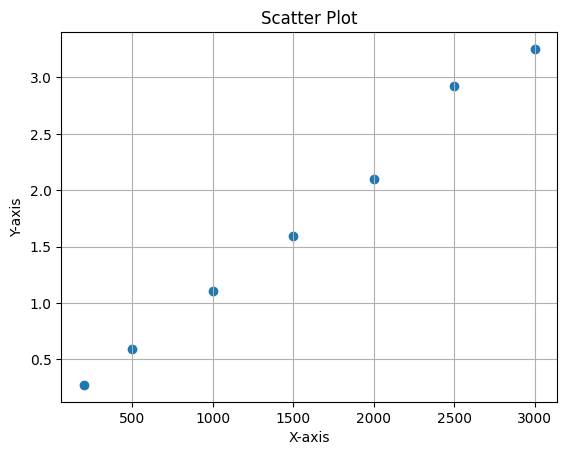

In [14]:
# Scatter plot
plt.scatter(x_values, np.sqrt(y_values))
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Scatter Plot')
plt.grid(True)
plt.show()

In [15]:
coefficient = np.sqrt(y_values[-1]) / x_values[-1]
def pred_time(n):
    return (coefficient * n) ** 2
pred_time(210000) / 3600

14.401612394385864

In [16]:
coefficient

0.0010842701822484707

5000 + 5000 + 5000 + ... + 5000 = 5000 ** 2

0 + 1 + 2 + 3 + 4 + ... + 4999 = 4999 * 5000 / 2

In [17]:
print(5000 ** 2, 4999 * 5000 / 2)

25000000 12497500.0


In [18]:
def triangular_numbers(n):
    return n * (n - 1) / 2

[(n, triangular_numbers(n)) for n in range(20)]

[(0, 0.0),
 (1, 0.0),
 (2, 1.0),
 (3, 3.0),
 (4, 6.0),
 (5, 10.0),
 (6, 15.0),
 (7, 21.0),
 (8, 28.0),
 (9, 36.0),
 (10, 45.0),
 (11, 55.0),
 (12, 66.0),
 (13, 78.0),
 (14, 91.0),
 (15, 105.0),
 (16, 120.0),
 (17, 136.0),
 (18, 153.0),
 (19, 171.0)]